In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

In [475]:
pd.read_csv?

In [480]:
final = pd.read_csv('df_final_speed_encoded.csv', index_col = 'Unnamed: 0')

In [482]:
final

,HOUR,MAKE,BODY_TYP,MOD_YEAR,AGE,INJ_SEV,REST_USE,EJECTION,VE_FORMS,VSURCOND,ROLLOVER,TRAV_SP,VSPD_LIM,LGT_COND,DIF_SP
0,22,Toyota,Pickups,8.0,23,No Apparent Injury,1,0,1,0,0,75,70,2,5
1,0,Chevrolet,Pickups,15.0,40,No Apparent Injury,1,0,2,0,0,70,70,2,0
2,12,Jeep,SUVs,3.0,38,Fatal Injury,1,0,3,1,0,65,70,0,-5
3,12,Jeep,SUVs,3.0,30,Suspected Serious Injury,1,0,3,1,0,65,70,0,-5
4,21,Hyundai,Sedans,3.0,24,Fatal Injury,1,0,2,0,0,30,55,2,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13634,8,Ford,Pickups,42.0,18,Fatal Injury,1,1,2,1,0,35,70,0,-35
13635,9,Chevrolet,Pickups,11.0,39,Possible Injury,1,0,1,1,1,50,80,0,-30
13636,9,Chevrolet,Pickups,11.0,38,Fatal Injury,0,1,1,1,1,50,80,0,-30
13637,9,Chevrolet,Pickups,11.0,41,Possible Injury,1,0,1,1,1,50,80,0,-30


In [316]:
inj_str = ['No Apparent Injury', 'Possible Injury', 'Suspected Minor Injury', 
        'Suspected Serious Injury', 'Fatal Injury', 'Injured, Severity Unknown', 
        'Died Prior to Crash', '','','Unknown']
def change_inj(injury):
    for i in range(0,10):
        if injury == i:
            injury = inj_str[i]
    return injury

1. Daylight
2. Dark – Not Lighted
3. Dark – Lighted
4. Dawn
5. Dusk
6. Dark – Unknown Lighting
7. Other
8. Not Reported
9. Reported as Unknown

In [317]:
light = [1]
dark = [2,3,6]
part_dark = [4,5]
def change_lgt(LGT_COND):
    if LGT_COND in light:
        LGT_COND = 0
    if LGT_COND in part_dark:
        LGT_COND = 1
    if LGT_COND in dark:
        LGT_COND = 2
    return LGT_COND

In [318]:
dry = [1]
wet = [2,3,4]
def change_vsur(VSURCOND):
    if VSURCOND in dry:
        VSURCOND = 0
    if VSURCOND in wet:
        VSURCOND = 1
    return VSURCOND

In [319]:
def change_ro(ROLLOVER):
    if ROLLOVER == 9:
        ROLLOVER = 3
    return ROLLOVER

In [320]:
final = final[final.VSURCOND <= 4]
final = final[final.VSURCOND != 0]
final = final[(final.INJ_SEV <= 4)]
final = final[(final.LGT_COND <= 6)]

In [321]:
final['INJ_SEV'] = final.INJ_SEV.apply(change_inj)
final.LGT_COND = final.LGT_COND.apply(change_lgt)
final.ROLLOVER = final.ROLLOVER.apply(change_ro)
final.VSURCOND = final.VSURCOND.apply(change_vsur)
final.MOD_YEAR = 2019 - final.MOD_YEAR

In [515]:
final.LGT_COND.value_counts()

0    6885
2    5934
1     593
Name: LGT_COND, dtype: int64

In [334]:
final['DIF_SP'] = final.TRAV_SP - final.VSPD_LIM

In [336]:
#final = final.drop('Unnamed: 0', axis = 1)
final

,HOUR,MAKE,BODY_TYP,MOD_YEAR,AGE,INJ_SEV,REST_USE,EJECTION,VE_FORMS,VSURCOND,ROLLOVER,TRAV_SP,VSPD_LIM,LGT_COND,DIF_SP
0,22,Toyota,Pickups,8.0,23,No Apparent Injury,1,0,1,0,0,75,70,2,5
1,0,Chevrolet,Pickups,15.0,40,No Apparent Injury,1,0,2,0,0,70,70,2,0
2,12,Jeep,SUVs,3.0,38,Fatal Injury,1,0,3,1,0,65,70,0,-5
3,12,Jeep,SUVs,3.0,30,Suspected Serious Injury,1,0,3,1,0,65,70,0,-5
4,21,Hyundai,Sedans,3.0,24,Fatal Injury,1,0,2,0,0,30,55,2,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13634,8,Ford,Pickups,42.0,18,Fatal Injury,1,1,2,1,0,35,70,0,-35
13635,9,Chevrolet,Pickups,11.0,39,Possible Injury,1,0,1,1,1,50,80,0,-30
13636,9,Chevrolet,Pickups,11.0,38,Fatal Injury,0,1,1,1,1,50,80,0,-30
13637,9,Chevrolet,Pickups,11.0,41,Possible Injury,1,0,1,1,1,50,80,0,-30


In [341]:
final.to_csv("df_final_speed_encoded.csv")

In [325]:
final.INJ_SEV.value_counts()

Fatal Injury                4513
No Apparent Injury          3982
Suspected Minor Injury      1885
Suspected Serious Injury    1647
Possible Injury             1385
Name: INJ_SEV, dtype: int64

In [342]:
from sklearn.compose import ColumnTransformer as ctf
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ct = ctf([
    ('onehot', OneHotEncoder(), [0, 1]),
    ('nothing', 'passthrough', [2])
], sparse_threshold=0)
inputs = ct.fit_transform(X)

In [343]:
final.columns

Index(['HOUR', 'MAKE', 'BODY_TYP', 'MOD_YEAR', 'AGE', 'INJ_SEV', 'REST_USE',
       'EJECTION', 'VE_FORMS', 'VSURCOND', 'ROLLOVER', 'TRAV_SP', 'VSPD_LIM',
       'LGT_COND', 'DIF_SP'],
      dtype='object')

In [373]:
X = final[['MAKE', 'BODY_TYP','REST_USE', 
           'EJECTION','VSURCOND', 'ROLLOVER', 'LGT_COND']].values
X,X.shape

(array([['Toyota', 'Pickups', 1, ..., 0, 0, 2],
        ['Chevrolet', 'Pickups', 1, ..., 0, 0, 2],
        ['Jeep', 'SUVs', 1, ..., 1, 0, 0],
        ...,
        ['Chevrolet', 'Pickups', 0, ..., 1, 1, 0],
        ['Chevrolet', 'Pickups', 1, ..., 1, 1, 0],
        ['BMW', 'Pickups', 1, ..., 0, 1, 2]], dtype=object), (13412, 7))

In [376]:
final.MAKE.value_counts()

Chevrolet    2962
Ford         2746
Toyota       2187
Honda        1281
BMW          1189
Dodge        1016
GMC           698
Jeep          696
Hyundai       637
Name: MAKE, dtype: int64

In [407]:
ct = ctf([
    ('onehot', OneHotEncoder(), [0,1,2,3,4,5,6]),
    ('nothing', 'passthrough', [2])
], sparse_threshold=0)
X = ct.fit_transform(X)

In [409]:
X, X.shape

(array([[0.0, 0.0, 0.0, ..., 0.0, 1.0, 1],
        [0.0, 1.0, 0.0, ..., 0.0, 1.0, 1],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 1],
        ...,
        [0.0, 1.0, 0.0, ..., 0.0, 0.0, 0],
        [0.0, 1.0, 0.0, ..., 0.0, 0.0, 1],
        [1.0, 0.0, 0.0, ..., 0.0, 1.0, 1]], dtype=object), (13412, 28))

In [417]:
one_hot

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13407,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,1
13408,0,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1
13409,0,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
13410,0,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1


In [425]:
cols = [ 'MOD_YEAR', 'VE_FORMS','TRAV_SP','VSPD_LIM','INJ_SEV' ]

In [449]:
one_hot = pd.DataFrame(X)
one_hot = one_hot.join(final[cols])
one_hot = one_hot.dropna()
one_hot

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,MOD_YEAR,VE_FORMS,TRAV_SP,VSPD_LIM,INJ_SEV
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,8.0,1.0,75.0,70.0,No Apparent Injury
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,1,15.0,2.0,70.0,70.0,No Apparent Injury
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,3.0,3.0,65.0,70.0,Fatal Injury
3,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,3.0,3.0,65.0,70.0,Suspected Serious Injury
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,3.0,2.0,30.0,55.0,Fatal Injury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13407,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,1,11.0,3.0,55.0,45.0,No Apparent Injury
13408,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,1,11.0,3.0,55.0,45.0,No Apparent Injury
13409,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,11.0,3.0,55.0,45.0,No Apparent Injury
13410,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,1,6.0,6.0,4.0,70.0,Suspected Minor Injury


In [450]:
one_hot.to_csv("df_final_speed_onehot")

In [492]:
final.MAKE.value_counts()

Chevrolet    2962
Ford         2746
Toyota       2187
Honda        1281
BMW          1189
Dodge        1016
GMC           698
Jeep          696
Hyundai       637
Name: MAKE, dtype: int64

In [499]:
final

,HOUR,MAKE,BODY_TYP,MOD_YEAR,AGE,INJ_SEV,REST_USE,EJECTION,VE_FORMS,VSURCOND,ROLLOVER,TRAV_SP,VSPD_LIM,LGT_COND,DIF_SP
0,22,Toyota,Pickups,8.0,23,No Apparent Injury,1,0,1,0,0,75,70,2,5
1,0,Chevrolet,Pickups,15.0,40,No Apparent Injury,1,0,2,0,0,70,70,2,0
2,12,Jeep,SUVs,3.0,38,Fatal Injury,1,0,3,1,0,65,70,0,-5
3,12,Jeep,SUVs,3.0,30,Suspected Serious Injury,1,0,3,1,0,65,70,0,-5
4,21,Hyundai,Sedans,3.0,24,Fatal Injury,1,0,2,0,0,30,55,2,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13634,8,Ford,Pickups,42.0,18,Fatal Injury,1,1,2,1,0,35,70,0,-35
13635,9,Chevrolet,Pickups,11.0,39,Possible Injury,1,0,1,1,1,50,80,0,-30
13636,9,Chevrolet,Pickups,11.0,38,Fatal Injury,0,1,1,1,1,50,80,0,-30
13637,9,Chevrolet,Pickups,11.0,41,Possible Injury,1,0,1,1,1,50,80,0,-30


In [500]:
final.MAKE = pd.factorize(final.MAKE)[0]
final.BODY_TYP = pd.factorize(final.BODY_TYP)[0]

In [501]:
final.head()

,HOUR,MAKE,BODY_TYP,MOD_YEAR,AGE,INJ_SEV,REST_USE,EJECTION,VE_FORMS,VSURCOND,ROLLOVER,TRAV_SP,VSPD_LIM,LGT_COND,DIF_SP
0,22,0,0,8.0,23,No Apparent Injury,1,0,1,0,0,75,70,2,5
1,0,1,0,15.0,40,No Apparent Injury,1,0,2,0,0,70,70,2,0
2,12,2,1,3.0,38,Fatal Injury,1,0,3,1,0,65,70,0,-5
3,12,2,1,3.0,30,Suspected Serious Injury,1,0,3,1,0,65,70,0,-5
4,21,3,2,3.0,24,Fatal Injury,1,0,2,0,0,30,55,2,-25


## Feature Selection

In [502]:
y = final.INJ_SEV
x = final.drop(['INJ_SEV'],axis=1)


In [505]:
RFE?

In [699]:
#Recursive Feature Elimination to select feactures by considering smaller and smaller sets of features
model = LogisticRegression(solver = 'lbfgs', multi_class = 'ovr', max_iter = 1000)
rfe = RFE(model, 8)
rfe = rfe.fit(x, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(x.columns[rfe.support_]))

Selected features: ['BODY_TYP', 'MOD_YEAR', 'REST_USE', 'EJECTION', 'VE_FORMS', 'VSURCOND', 'ROLLOVER', 'LGT_COND']


In [507]:
features = ['BODY_TYP', 'MOD_YEAR', 'REST_USE', 'EJECTION', 'VE_FORMS', 'VSURCOND', 'ROLLOVER', 'LGT_COND']

In [701]:
#Recursive Feature Elimination to select feactures by considering smaller and smaller sets of features
model = LinearSVC(max_iter = 3000)
rfe = RFE(model, 8)
rfe = rfe.fit(x, y)
# summarize the selection of the attributes
print('SVC: Selected features: %s' % list(x.columns[rfe.support_]))

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

SVC: Selected features: ['HOUR', 'BODY_TYP', 'REST_USE', 'EJECTION', 'VE_FORMS', 'VSURCOND', 'ROLLOVER', 'LGT_COND']


C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [702]:
#Recursive Feature Elimination to select feactures by considering smaller and smaller sets of features
model = DecisionTreeClassifier(criterion = 'gini', splitter = 'best')
rfe = RFE(model, 8)
rfe = rfe.fit(x, y)
# summarize the selection of the attributes
print('Decision Trees: Selected features: %s' % list(x.columns[rfe.support_]))

Decision Trees: Selected features: ['HOUR', 'MAKE', 'MOD_YEAR', 'AGE', 'REST_USE', 'TRAV_SP', 'VSPD_LIM', 'DIF_SP']


In [510]:
x_features = x[features]

1. Daylight
2. Dark – Not Lighted
3. Dark – Lighted
4. Dawn
5. Dusk
6. Dark – Unknown Lighting
7. Other
8. Not Reported
9. Reported as Unknown

In [519]:
train_x, test_x, train_y, test_y = train_test_split(x_features, y, test_size = 0.2)

In [524]:
train_x

,BODY_TYP,MOD_YEAR,REST_USE,EJECTION,VE_FORMS,VSURCOND,ROLLOVER,LGT_COND
12072,1,4.0,1,0,14,0,0,0
10337,0,11.0,1,0,2,0,0,2
10475,1,6.0,1,0,1,1,0,0
2827,2,28.0,0,0,1,0,1,2
9637,0,24.0,1,0,2,1,0,0
...,...,...,...,...,...,...,...,...
568,1,25.0,1,0,2,0,0,0
9291,1,20.0,1,0,1,0,1,2
5276,1,15.0,1,0,2,1,0,0
13502,0,16.0,1,0,1,1,0,2


In [525]:
x.VSURCOND.value_counts()

0    11425
1     1987
Name: VSURCOND, dtype: int64

In [25]:
#Normalizing Inputs to speed up SVM, and boost its performance
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [514]:
x.VSPD_LIM.value_counts()

55    3868
45    2588
65    1457
35    1219
70    1170
40     923
60     535
50     492
25     441
30     414
75     187
80      54
15      28
20      14
0       12
5        6
10       4
Name: VSPD_LIM, dtype: int64

## SVM

In [ ]:
SVC?

In [687]:
svm = LinearSVC()
svm.fit(train_x, train_y)

C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [688]:
test_predictions = svm.predict(test_x)
conf_mat = confusion_matrix(test_y, test_predictions)
print('Accuracy:')
print(accuracy_score(test_y, test_predictions))
print('Confusion Matrix:')
print(conf_mat)
print(classification_report(test_y,test_predictions))

Accuracy:
0.49385016772269846
Confusion Matrix:
[[591 295   0  16   0]
 [100 724   1   3   0]
 [ 58 224   0   6   0]
 [141 199   0  10   0]
 [149 153   0  13   0]]
                          precision    recall  f1-score   support

            Fatal Injury       0.57      0.66      0.61       902
      No Apparent Injury       0.45      0.87      0.60       828
         Possible Injury       0.00      0.00      0.00       288
  Suspected Minor Injury       0.21      0.03      0.05       350
Suspected Serious Injury       0.00      0.00      0.00       315

                accuracy                           0.49      2683
               macro avg       0.25      0.31      0.25      2683
            weighted avg       0.36      0.49      0.40      2683



C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [623]:
pd.DataFrame(test_predictions)[0].value_counts()

No Apparent Injury        1692
Fatal Injury               786
Suspected Minor Injury     205
Name: 0, dtype: int64

In [694]:
final

,HOUR,MAKE,BODY_TYP,MOD_YEAR,AGE,INJ_SEV,REST_USE,EJECTION,VE_FORMS,VSURCOND,ROLLOVER,TRAV_SP,VSPD_LIM,LGT_COND,DIF_SP
0,22,0,0,8.0,23,No Apparent Injury,1,0,1,0,0,75,70,2,5
1,0,1,0,15.0,40,No Apparent Injury,1,0,2,0,0,70,70,2,0
2,12,2,1,3.0,38,Fatal Injury,1,0,3,1,0,65,70,0,-5
3,12,2,1,3.0,30,Suspected Serious Injury,1,0,3,1,0,65,70,0,-5
4,21,3,2,3.0,24,Fatal Injury,1,0,2,0,0,30,55,2,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13634,8,6,0,42.0,18,Fatal Injury,1,1,2,1,0,35,70,0,-35
13635,9,1,0,11.0,39,Possible Injury,1,0,1,1,1,50,80,0,-30
13636,9,1,0,11.0,38,Fatal Injury,0,1,1,1,1,50,80,0,-30
13637,9,1,0,11.0,41,Possible Injury,1,0,1,1,1,50,80,0,-30


In [656]:
cm_cols = ['Fatal Injury', 'No Apparent Injury','Possible Injury','(S) Minor Injury','(S) Serious Injury']

In [689]:
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_mat_normalized, index= cm_cols, columns=cm_cols)

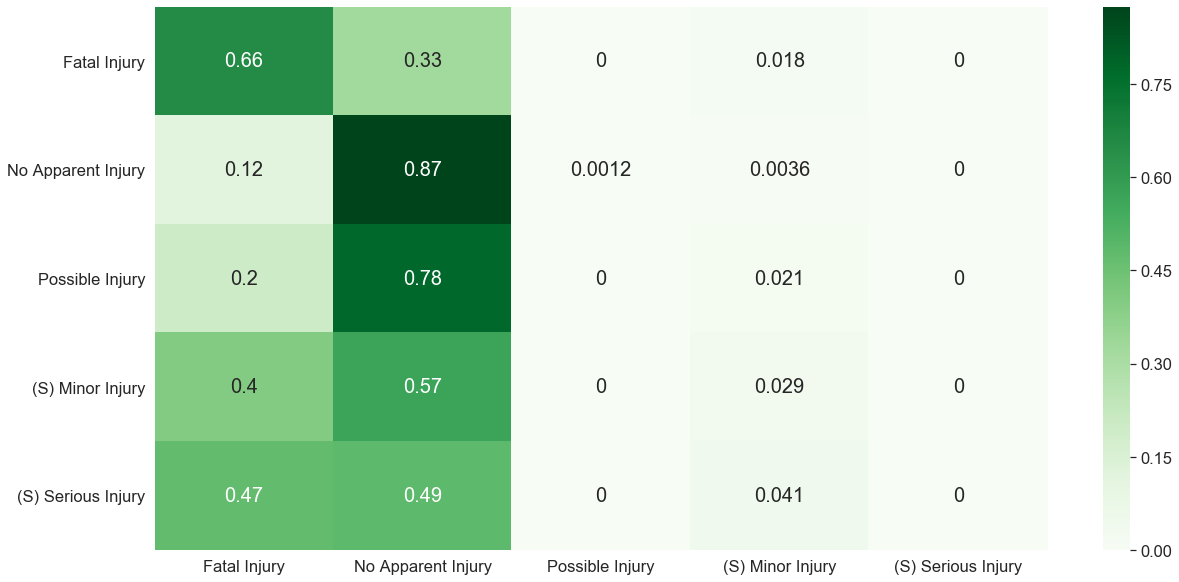

In [690]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set(font_scale=1.5)#for label size
sns.heatmap(df_cm,cmap='Greens',annot=True,annot_kws={"size": 20})# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('Plots/svm_cm.png')
plt.show()


In [526]:
#For each INJ Severity, set 1 of the inj_sev labels into 1, and rest into 0
for i in train_y.unique():

    train_y1 = pd.get_dummies(train_y)[i]

    test_y1 = pd.get_dummies(test_y)[i]

    svm = SVC(gamma = 0.5, C = 0.5)
    svm.fit(train_x, train_y1)

    test_predictions = svm.predict(test_x)
    conf_mat = confusion_matrix(test_y1, test_predictions)
    print('Accuracy:' + i)
    print(accuracy_score(test_y1, test_predictions))
    print('Confusion Matrix:')
    print(conf_mat)

Accuracy:No Apparent Injury
0.7487886693999255
Confusion Matrix:
[[1720  135]
 [ 539  289]]
Accuracy:Suspected Serious Injury
0.8825941110696981
Confusion Matrix:
[[2368    0]
 [ 315    0]]
Accuracy:Possible Injury
0.8926574729780097
Confusion Matrix:
[[2395    0]
 [ 288    0]]
Accuracy:Suspected Minor Injury
0.8695490122996645
Confusion Matrix:
[[2333    0]
 [ 350    0]]
Accuracy:Fatal Injury
0.7376071561684682
Confusion Matrix:
[[1588  193]
 [ 511  391]]


In [191]:
SVC?

#### Testing Radial SVM

In [1]:
i = 'Fatal Injury'
train_y1 = pd.get_dummies(train_y)[i]
test_y1 = pd.get_dummies(test_y)[i]

svm = SVC(gamma = 0.5, C = 0.5)
svm.fit(train_x, train_y1)
test_predictions = svm.predict(test_x)
conf_mat = confusion_matrix(test_y1, test_predictions)
print('Accuracy:' + i)
print(accuracy_score(test_y1, test_predictions))
print('Confusion Matrix:')
print(conf_mat)

NameError: name 'pd' is not defined

#### Testing Linear SVM

In [32]:
i = 'Fatal Injury'
train_y1 = pd.get_dummies(train_y)[i]
test_y1 = pd.get_dummies(test_y)[i]

svm = SVC(kernel = 'linear')
svm.fit(train_x, train_y1)
test_predictions = svm.predict(test_x)
conf_mat = confusion_matrix(test_y1, test_predictions)
print('Accuracy:' + i)
print(accuracy_score(test_y1, test_predictions))
print('Confusion Matrix:')
print(conf_mat)

Accuracy:Suspected Serious Injury
0.7174397407332388
Confusion Matrix:
[[5299  812]
 [1978 1785]]


## Decision Trees

In [681]:
dt = DecisionTreeClassifier(criterion = 'gini', splitter = 'best')
#print(cross_val_score(dt, train_x, train_y1, cv=10))
dt.fit(train_x, train_y)
test_preds = dt.predict(test_x)
conf_mat = confusion_matrix(test_y, test_preds)
print('Accuracy:')
print(accuracy_score(test_y, test_preds))
print('Confusion Matrix:')
print(conf_mat)

Accuracy:
0.476332463660082
Confusion Matrix:
[[553 177  32  70  70]
 [152 588  28  36  24]
 [ 92 118  43  24  11]
 [122 126  20  64  18]
 [146  93  13  33  30]]


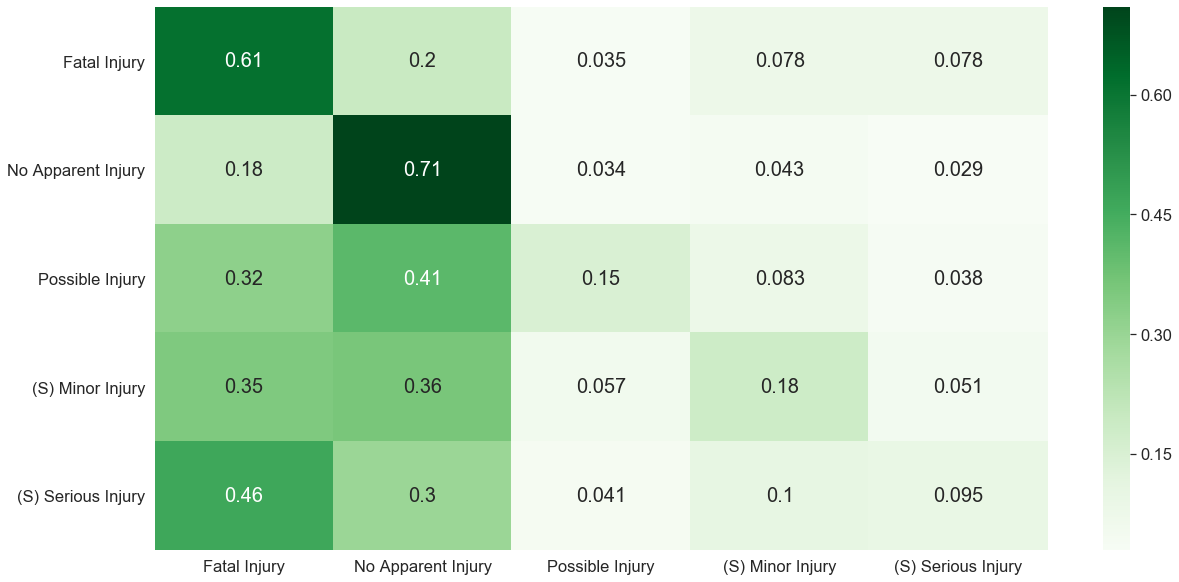

In [682]:
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_mat_normalized, index= cm_cols, columns=cm_cols)

fig, ax = plt.subplots(figsize=(20,10))
sns.set(font_scale=1.5)#for label size
sns.heatmap(df_cm,cmap='Greens',annot=True,annot_kws={"size": 20})# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('Plots/svm_DT.png')
plt.show()

In [456]:
for i in train_y.unique():

    train_y1 = pd.get_dummies(train_y)[i]

    test_y1 = pd.get_dummies(test_y)[i]
    
    dt = DecisionTreeClassifier(criterion = 'gini', splitter = 'best')
    #print(cross_val_score(dt, train_x, train_y1, cv=10))
    dt.fit(train_x, train_y1)
    test_preds = dt.predict(test_x)
    conf_mat = confusion_matrix(test_y1, test_preds)
    print('Accuracy:' +i)
    print(accuracy_score(test_y1, test_preds))
    print('Confusion Matrix:')
    print(conf_mat)

Accuracy:Suspected Serious Injury
0.7971948445792267
Confusion Matrix:
[[2036  301]
 [ 234   67]]
Accuracy:Fatal Injury
0.6084154662623199
Confusion Matrix:
[[1268  482]
 [ 551  337]]
Accuracy:Suspected Minor Injury
0.7589082638362395
Confusion Matrix:
[[1914  342]
 [ 294   88]]
Accuracy:Possible Injury
0.813874147081122
Confusion Matrix:
[[2104  257]
 [ 234   43]]
Accuracy:No Apparent Injury
0.6914329037149356
Confusion Matrix:
[[1439  409]
 [ 405  385]]


In [457]:
TEST = pd.read_csv("df_final_speed.csv")
TEST.TRAV_SP.value_counts()

55     1850
0      1382
45     1303
70      889
65      863
       ... 
114       2
113       1
122       1
111       1
125       1
Name: TRAV_SP, Length: 121, dtype: int64

In [121]:
RFE?

## Log Regression

In [695]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'ovr', max_iter = 1000)
# create the RFE model and select 8 attributes
rfe = RFE(model, 6)
rfe = rfe.fit(x, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(x.columns[rfe.support_]))

Selected features: ['BODY_TYP', 'REST_USE', 'EJECTION', 'VSURCOND', 'ROLLOVER', 'LGT_COND']


In [ ]:
LogisticRegression

In [116]:
cols = ['BODY_TYP', 'MOD_YEAR', 'REST_USE', 'EJECTION', 'VE_FORMS', 'VSURCOND', 'ROLLOVER', 'LGT_COND']
y = final.INJ_SEV
x = final[cols]
#x.MOD_YEAR = 2019 - x.MOD_YEAR
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

D:\Anaconda\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [104]:
test_x.shape

(9874, 8)

In [8]:
LogisticRegression?

In [683]:
#LR does one vs rest classification on its own...
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(train_x, train_y)
test_preds = model.predict(test_x)
conf_mat = confusion_matrix(test_y, test_preds)
print('Accuracy:')
print(accuracy_score(test_y, test_preds))
print('Confusion Matrix:')
print(conf_mat)
print(classification_report(test_y,test_preds))

Accuracy:
0.4949683190458442
Confusion Matrix:
[[607 270   0  25   0]
 [114 707   3   4   0]
 [ 60 214   1  13   0]
 [144 192   1  13   0]
 [148 147   0  20   0]]
                          precision    recall  f1-score   support

            Fatal Injury       0.57      0.67      0.61       902
      No Apparent Injury       0.46      0.85      0.60       828
         Possible Injury       0.20      0.00      0.01       288
  Suspected Minor Injury       0.17      0.04      0.06       350
Suspected Serious Injury       0.00      0.00      0.00       315

                accuracy                           0.49      2683
               macro avg       0.28      0.31      0.26      2683
            weighted avg       0.38      0.49      0.40      2683



C:\Users\taq19\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


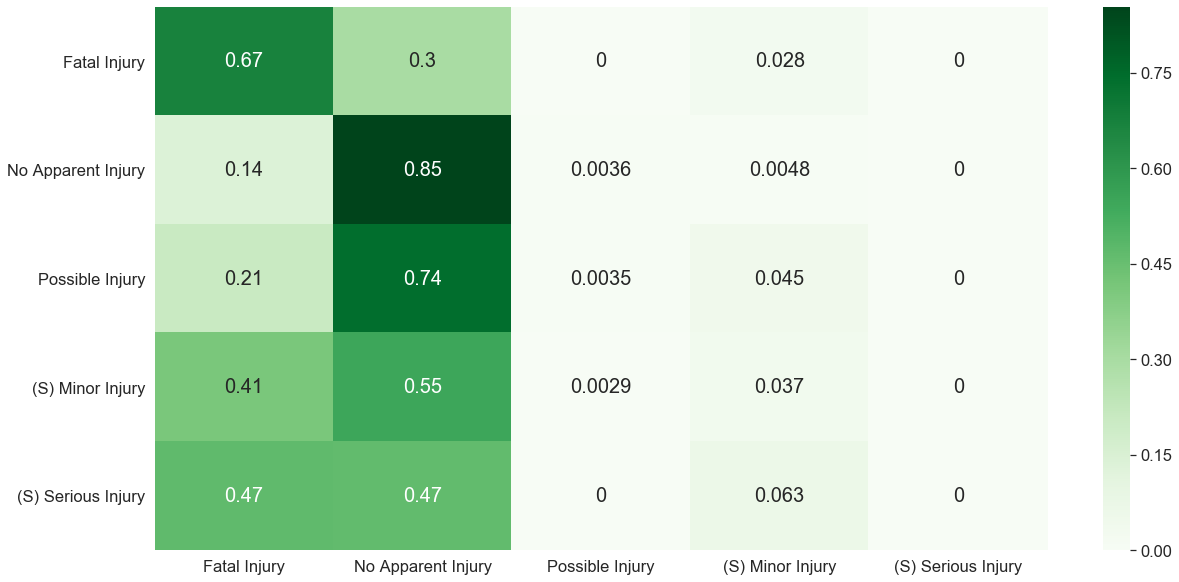

In [684]:
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_mat_normalized, index= cm_cols, columns=cm_cols)

fig, ax = plt.subplots(figsize=(20,10))
sns.set(font_scale=1.5)#for label size
sns.heatmap(df_cm,cmap='Greens',annot=True,annot_kws={"size": 20})# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('Plots/svm_LR.png')
plt.show()

In [460]:
for i in train_y.unique():

    train_y1 = pd.get_dummies(train_y)[i]

    test_y1 = pd.get_dummies(test_y)[i]
    
    model = LogisticRegression(solver='lbfgs',max_iter = 1000)
    
    model.fit(train_x, train_y1)
    test_preds = model.predict(test_x)
    conf_mat = confusion_matrix(test_y1, test_preds)
    print('Accuracy:' + i)
    print(accuracy_score(test_y1, test_preds))
    print('Confusion Matrix:')
    print(conf_mat)

Accuracy:Suspected Serious Injury
0.8858984078847612
Confusion Matrix:
[[2337    0]
 [ 301    0]]
Accuracy:Fatal Injury
0.6815769522365428
Confusion Matrix:
[[1618  132]
 [ 708  180]]
Accuracy:Suspected Minor Injury
0.8551933282789992
Confusion Matrix:
[[2256    0]
 [ 382    0]]
Accuracy:Possible Injury
0.8949962092494314
Confusion Matrix:
[[2361    0]
 [ 277    0]]
Accuracy:No Apparent Injury
0.6948445792266869
Confusion Matrix:
[[1724  124]
 [ 681  109]]


In [60]:
LogisticRegression?